## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, Nadam
from keras import regularizers

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    
def draw_roc_curve(y, pred):
    from matplotlib import pyplot as plt

    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()
    
import financial_distress_functions as fn

Requirement already up-to-date: seaborn in f:\anaconda3\envs\py3_6\lib\site-packages (0.9.0)


Using TensorFlow backend.


## Data Schema

Column name     | Description
             ---|---
RorNumber       |    Row number

---


---



# Purpose: 


In [2]:
# raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_churn.csv")
# raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_financial_churn.csv")
# raw.head()
raw = pd.read_csv('https://storage.googleapis.com/allianz-course/data/raw_financial_distess.csv').rename(columns={'Financial Distress': 'distress_num'})
raw.head(10)

,Company,Time,distress_num,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.28100,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.27000,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.05290,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.11310,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.06230,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27
5,2,2,0.007188,1.05580,0.081916,0.87949,0.68673,0.142630,0.043102,0.77198,...,107.090,31.31,30.194,17.000,16.0,0.4,29,1.357300,8,28
6,2,3,1.200200,0.97059,0.076064,0.90677,0.80980,0.165920,-0.024649,0.73660,...,120.870,36.07,35.273,17.000,15.0,-0.2,29,0.007188,9,29
7,2,4,2.234800,1.05900,0.130200,0.81811,0.87599,0.234450,0.045576,0.78727,...,54.806,39.80,38.377,17.167,16.0,5.6,29,1.200200,10,30
8,2,5,1.340500,1.12450,0.147840,0.75871,1.07990,0.276440,0.089408,0.80356,...,59.806,44.53,42.822,15.500,14.0,2.1,29,2.234800,11,31
9,2,6,2.047400,1.59980,0.262460,0.54615,1.31270,0.369480,0.296640,0.85364,...,66.262,52.74,49.206,15.500,12.0,-6.4,29,1.340500,12,32


## Features setting

In [3]:
catg_features = ['x80'] # 'Company', 
num_features = [f'x{i}' for i in range(1, 84) if i != 80]
# embedding_features = catg_features + ['binn_tenure', 'binn_MonthlyCharges', 'binn_TotalCharges']
label = 'distress_catg'

In [4]:
# Rolling mean
# raw['rolling_mean'] = (raw.groupby('Company', group_keys=False)
#                           .apply(lambda pipe: pipe['distress_num'].rolling(window=3).mean().fillna(0))
#                           .values)

# Split train valid
def split_fn(pipe):
    lens = len(pipe)
    ret = np.ones(lens)
    if lens >= 5:
        split_size = int(lens * 0.36)
        ret[-split_size:] = 0
    return ret

# # Split train valid
# def split_fn(pipe):
#     lens = len(pipe)
#     ret = np.ones(lens)
#     if lens > 1:
#         split_size = int(lens * 0.36)
#         ret[-1:] = 0
#     return ret

raw['distress_catg'] = (raw.distress_num <= -0.5).astype(int)
raw['is_train'] = np.concatenate(raw.groupby('Company').apply(split_fn).values)
raw_vl = raw.query("is_train == 0").drop('is_train', 1)
raw = raw.query("is_train == 1").drop('is_train', 1)
raw.head()

,Company,Time,distress_num,x1,x2,x3,x4,x5,x6,x7,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,distress_catg
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49,0
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50,0
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51,0
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52,1
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27,0


In [5]:
raw.to_csv('../data/raw_tr_financial_distree.csv', index=False)
raw_vl.to_csv('../data/raw_vl_financial_distree.csv', index=False)

In [6]:
corr = raw.corr()
corr['distress_num'][(corr['distress_num'] <= -0.3) | (corr['distress_num'] >= 0.3)]

distress_num    1.000000
x25             0.302677
x48             0.395974
x81             0.385780
Name: distress_num, dtype: float64

## Base Feature Preprocessing

* Normalize ofr numeric features
* One Hot Encoding for categorical features

In [7]:
def feature_engineering(raw, is_train=True, status=None):
    data = raw.copy()
    
    if is_train:
        status = {'scaler': None, 
                  'mapper': defaultdict(LabelBinarizer),
                  'woe_mapper': {},
                  'binn_mapper': {},
                  'freq_mapper': {},
                  'mean_mapper': {},
                  'rfm_mapper': {}}

    catg_ftrs = catg_features.copy()
        
    # Numeric binning to categorical features
    do_binning(catg_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    catg_part = pd.DataFrame()
    
    # One Hot Encoding
    # catg_part = pd.get_dummies(data[catg_ftrs])
    do_onehot(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Embedding, simple indexing categorical features, actual embedding function in keras
    # do_embedding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # RFM
    do_rfm(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    do_woe_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Frequency encoding, target mean encoding
    do_target_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Normalize
    num_part = do_norm(num_features, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # Merge categorical, numeric features
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['distress_catg'].copy()
    
    # Include quadratic term, cube term
    do_nth_order_polynominal(num_features, data_x)
    # ----------------------------------------------------------------------------------------- 
    # todo hack
    # data_x['distress_num'] = data['distress_num'].values
    return data_x, data_y, status


do_binning = fn.do_binning
do_onehot = fn.do_onehot
do_embedding = fn.do_embedding
do_woe_encoding = fn.do_woe_encoding
do_target_encoding = fn.do_target_encoding
do_norm = fn.do_norm
do_nth_order_polynominal = fn.do_nth_order_polynominal
do_rfm = fn.do_rfm

## Functions of Features Processing

In [8]:
# def do_binning(catg_ftrs, status, data, is_train):
#     pass

# def do_onehot(catg_ftrs, catg_part, status, data, is_train):
#     mapper = status['mapper']
#     tmp = []
#     for catg_col in catg_ftrs:
#         if is_train:
#             result = mapper[catg_col].fit_transform(data[catg_col])
#         else:
#             result = mapper[catg_col].transform(data[catg_col])

#         columns = [f'{catg_col}_{col}' for col in mapper[catg_col].classes_]
#         if result.shape[1] == 1:
#             columns = columns[:1]
#         tmp.append(pd.DataFrame(data=result, columns=columns))
#     tmp = pd.concat(tmp, 1)
#     for col in tmp:
#         catg_part[col] = tmp[col]
#     pass

# def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):
#     pass

# def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
#     pass

# def do_norm(num_features, status, data, is_train):
#     num_part = data[num_features].copy()
#     if is_train:
#         scaler = StandardScaler()
#         status['scaler'] = scaler
#         num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
#     else:
#         scaler = status['scaler']
#         num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
#     return num_part
#     pass

# def do_nth_order_polynominal(num_features, data):
#     pass

In [9]:
def pred_dist(y_pred):
    y_pred = pd.Series(y_pred.ravel())
    print( y_pred.describe() )
    print( y_pred.mean(), y_pred.std() )
    sns.lineplot(range(len(y_pred)), sorted(y_pred.ravel()))
    plt.show()

    sns.boxplot(y_pred.ravel(), orient='v')
    plt.show()

    sns.distplot(y_pred.ravel())
    plt.show()

def f_beta_scann(y_true, y_pred, beta=0.5):
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1]
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]


def analyze(y_true, y_pred, beta=1):
    thres, f_beta = f_beta_scann(y_true, y_pred, beta=beta)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))

    print(classification_report(y_true, y_pred.ravel() > thres))

In [78]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
vl_x.head()

(2557, 123) (1115, 123)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,-2.494470,0.772896,0.829425,0.913489,0.133450,-0.002416,-0.864956,0.449784,0.581135,0.389179
1,0,0,0,0,0,0,0,0,0,0,...,-0.876136,0.331227,1.514342,1.652293,2.136938,-0.002416,-2.291199,0.285077,0.695291,0.464323
2,0,0,0,0,0,0,0,0,0,0,...,0.202754,0.102598,2.533857,2.694370,2.136938,-0.002416,-2.956780,0.635129,0.809446,0.539467
3,0,0,0,0,0,0,0,0,0,0,...,-0.336691,0.403973,3.146913,3.296358,3.530669,3.481836,1.258562,0.673756,0.923602,0.614611
4,0,0,0,0,0,0,0,0,0,0,...,-0.606413,0.341619,3.692601,3.524384,2.833803,2.784986,1.607200,0.578040,1.037758,0.689755


## Model on Base Featue Engineering

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7936      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

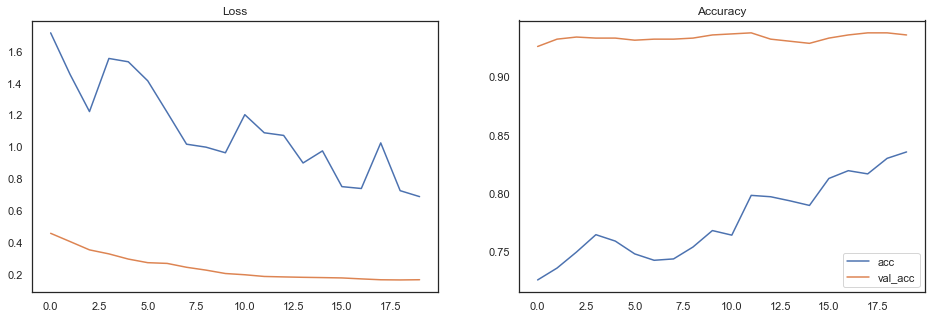

auc: 0.9266367796768469


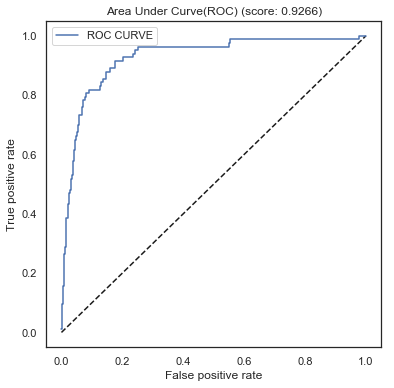

count    1115.000000
mean        0.083106
std         0.183359
min         0.000000
25%         0.000662
50%         0.006179
75%         0.050917
max         0.999250
dtype: float64
0.08310613 0.18335888


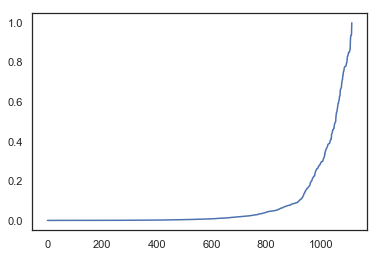

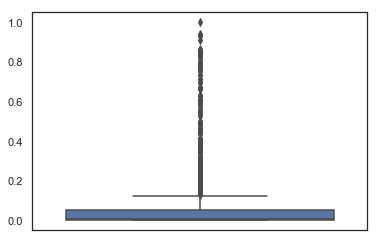

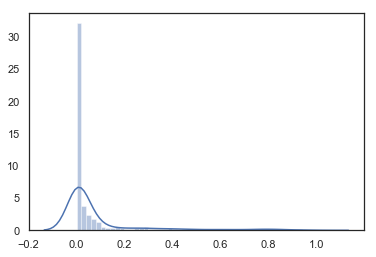

thres: 0.2725, f_beta score: 0.5922
accuracy@0.2725: 0.92

threshold@0.5, accuracy: 0.9372
[[1009   23]
 [  47   36]] 

threshold@0.2725, accuracy: 0.9247
[[970  62]
 [ 22  61]]
             precision    recall  f1-score   support

          0       0.98      0.94      0.96      1032
          1       0.50      0.73      0.59        83

avg / total       0.94      0.92      0.93      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

from keras import callbacks

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')

plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, 1)

## Analyze the Prediction

In [ ]:
y_pred = model.predict(vl_x)
y_pred

In [ ]:
def pred_dist(y_pred):
    y_pred = pd.Series(y_pred.ravel())
    print( y_pred.describe() )
    print( y_pred.mean(), y_pred.std() )
    sns.lineplot(range(len(y_pred)), sorted(y_pred.ravel()))
    plt.show()

    sns.boxplot(y_pred.ravel(), orient='v')
    plt.show()

    sns.distplot(y_pred.ravel())
    plt.show()
    
pred_dist(y_pred)

## Observation


---


## 找出最佳閥值

In [ ]:
# 依照所有的閥值(切割100等分)算出F score, 找出分數最高的閥值
def f_beta_scann(y_true, y_pred, beta=0.5):
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1] 
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]

def analyze(y_true, y_pred, beta=1):
    thres, f_beta = f_beta_scann(y_true, y_pred, beta=beta)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))
    
    print(classification_report(y_true, y_pred.ravel() > thres))

# analyze(vl_y, y_pred)

## Observation



## Bining Numeric Feature



In [ ]:
def do_binning(catg_ftrs, status, data, is_train):
    def quartile_binning(x):
        bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
        iqr_x_150 = (bins[-1] - bins[0]) * 1.5
        bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
        result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
        return result, bins

    for col in [f'x{i}' for i in range(1, 84) if i != 80]:
        binned_name = f'binn_{col}'
        if is_train:
            result, bins = quartile_binning(data[col])
            status['binn_mapper'][binned_name] = bins
            data[binned_name] = result
        else:
            bins = status['binn_mapper'][binned_name]
            data[binned_name] = pd.Series(np.digitize(data[col], bins))\
                                  .map(pd.Series([0, 1, 2, 3, 4, 0])).values

        catg_ftrs.append(binned_name)
    pass

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (Binning)

In [ ]:
def get_model(input_dim, emb_info, data):
    inputs = Input(shape=(input_dim,))
    emb_inputs = [Input(shape=(1,)) for col in emb_info]
    all_inputs = [inputs] + emb_inputs

    embeddings = [Flatten(name=name)(Embedding(emb_info[name], 6, input_length=1)(emb))
                  for name, emb in zip(emb_info.keys(), emb_inputs)]

    concat = Concatenate(axis=1)([inputs] + embeddings)
    nets = Dense(units=128, activation='selu')(concat)
    nets = Dropout(.5)(nets)
    nets = Dense(units=64, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=32, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=1, activation='linear')(nets)

    model = Model(inputs=all_inputs, outputs=nets)
    # model.summary()
    model.compile(optimizer='adam', loss='mse')
    return model

K.clear_session()
emb_info = {'Company': 422, 'x80': 37}
emb_info.update(dict((f'binn_x{i}', len(tr_x[f'binn_x{i}'].unique())) for i in range(1, 84) if i != 80))

model = get_model(len(num_features), emb_info, data=tr_x)
emb_features = list(emb_info.keys())
hist = model.fit([tr_x.drop(emb_features, 1)] + 
                 [tr_x[col][:, None] for col in tr_x[emb_features]],
                 tr_y, 
                 validation_data=([vl_x.drop(emb_features, 1)] + 
                                  [vl_x[col][:, None] for col in vl_x[emb_features]], 
                                  vl_y), 
                 batch_size=100, 
                 epochs=20)

plot_result(hist)
# draw_roc_curve(vl_y, model.predict(vl_x))

## Add Weight of Evidence Encoding

In [ ]:
def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):

    def woe_encode(x, label, data):
        """Calculate the Weight of Evidence of given categorical feature and label

        :param x: Given feature name
        :param label: Label name
        :param data:
        :return: WOE encoded dictionary
        """
        total_vc = data[label].value_counts().sort_index()

        def woe(pipe, total_vc):
            # Count by label in this group
            group_vc = pipe[label].value_counts().sort_index()

            # Some class in the feature is missing, fill zero to missing class
            if len(group_vc) < len(total_vc):
                for key in total_vc.index:
                    if key not in group_vc:
                        group_vc[key] = 0.
                group_vc = group_vc.sort_index()

            # WOE formula
            r = ((group_vc + 0.5) / total_vc).values

            # Odd ratio => 1 to 0, you can define meaning of each class
            return np.log(r[1] / r[0])

        return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))

    for catg_col in catg_ftrs:
        if is_train:
            kv = woe_encode(catg_col, 'Exited', data)
            status['woe_mapper'][catg_col] = kv.to_dict()
        else:
            kv = pd.Series(status['woe_mapper'][catg_col])
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    pass

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (WOE)

In [ ]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 20, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 20, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Statistical Encoding, Target Encoding

* Frequency encoding
* Mean encoding

In [ ]:
def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
    for catg_col in catg_ftrs:
        if is_train:
            freq_proportion = data[catg_col].value_counts() / len(data)
            catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
            target_mean = data.groupby(catg_col).Exited.mean()
            catg_part[f'mean_{catg_col}'] = target_mean.reindex(data[catg_col]).values

            status['freq_mapper'][catg_col] = freq_proportion.to_dict()
            status['mean_mapper'][catg_col] = target_mean.to_dict()
        else:
            catg_part[f'freq_{catg_col}'] = pd.Series(status['freq_mapper'][catg_col]).reindex(data[catg_col]).values
            catg_part[f'mean_{catg_col}'] = pd.Series(status['mean_mapper'][catg_col]).reindex(data[catg_col]).values
    pass

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
print(tr_x.columns.values)
tr_x.head()

## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding)

In [ ]:
def get_model(input_dim, emb_info, data):
    inputs = Input(shape=(input_dim,))
    emb_inputs = [Input(shape=(1,)) for col in emb_info]
    all_inputs = [inputs] + emb_inputs

    embeddings = [Flatten(name=name)(Embedding(emb_info[name], 6, input_length=1)(emb))
                  for name, emb in zip(emb_info.keys(), emb_inputs)]

    concat = Concatenate(axis=1)([inputs] + embeddings)
    nets = Dense(units=256, activation='selu')(concat)
    nets = Dropout(.5)(nets)
    nets = Dense(units=128, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=64, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=1, activation='linear')(nets)

    model = Model(inputs=all_inputs, outputs=nets)
    # model.summary()
    model.compile(optimizer='adam', loss='mse')
    return model

K.clear_session()
emb_info = {'Company': 422, 'x80': 37}
# emb_info.update(dict((f'binn_x{i}', len(tr_x[f'binn_x{i}'].unique())) for i in range(1, 84) if i != 80))
emb_features = list(emb_info.keys())

model = get_model(tr_x.drop(emb_features, 1).shape[1], emb_info, data=tr_x)
hist = model.fit([tr_x.drop(emb_features, 1)] + 
                 [tr_x[col][:, None] for col in tr_x[emb_features]],
                 tr_y, 
                 validation_data=([vl_x.drop(emb_features, 1)] + 
                                  [vl_x[col][:, None] for col in vl_x[emb_features]], 
                                  vl_y), 
                 batch_size=100, 
                 epochs=20)

plot_result(hist)

## Add Polynomial Featue Engineering

* Add quradratic, cube term base on numeric features

In [ ]:
# def do_nth_order_polynominal(num_features, data):
#     for num_col in num_features:
#         data[f'{num_col}_degree_2'] = data[num_col] ** 2
#         data[f'{num_col}_degree_3'] = data[num_col] ** 3
#     pass

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding + Polynominal)


In [ ]:
def get_model(input_dim, emb_info, data):
    inputs = Input(shape=(input_dim,))
    emb_inputs = [Input(shape=(1,)) for col in emb_info]
    all_inputs = [inputs] + emb_inputs

    embeddings = [Flatten(name=name)(Embedding(emb_info[name], 6, input_length=1)(emb))
                  for name, emb in zip(emb_info.keys(), emb_inputs)]

    concat = Concatenate(axis=1)([inputs] + embeddings)
    nets = Dense(units=256, activation='selu')(concat)
    nets = Dropout(.6)(nets)
    nets = Dense(units=128, activation='selu')(nets)
    nets = Dropout(.6)(nets)
    nets = Dense(units=64, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=1, activation='sigmoid')(nets)

    model = Model(inputs=all_inputs, outputs=nets)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

K.clear_session()
emb_info = {'Company': 422, 'x80': 37}
# emb_info.update(dict((f'binn_x{i}', len(tr_x[f'binn_x{i}'].unique())) for i in range(1, 84) if i != 80))
emb_features = list(emb_info.keys())

model = get_model(tr_x.drop(emb_features, 1).shape[1], emb_info, data=tr_x)
hist = model.fit([tr_x.drop(emb_features, 1)] + 
                 [tr_x[col][:, None] for col in tr_x[emb_features]],
                 tr_y, 
                 validation_data=([vl_x.drop(emb_features, 1)] + 
                                  [vl_x[col][:, None] for col in vl_x[emb_features]], 
                                  vl_y), 
                 batch_size=1000, 
                 epochs=30)

plot_result(hist)
draw_roc_curve(vl_y, model.predict([vl_x.drop(emb_features, 1)] + 
                                   [vl_x[col][:, None] for col in vl_x[emb_features]]))

In [ ]:
# 依照所有的閥值(切割100等分)算出F score, 找出分數最高的閥值
def f_beta_scann(y_true, y_pred, beta=0.5):
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1] 
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]

def analyze(y_true, y_pred, beta=0.5):
    thres, f_beta = f_beta_scann(y_true, y_pred, beta=beta)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))

In [ ]:
y_pred = model.predict([vl_x.drop(emb_features, 1)] + 
                       [vl_x[col][:, None] for col in vl_x[emb_features]])
analyze(vl_y, y_pred)
draw_roc_curve(vl_y, )

In [ ]:
sns.boxplot(y_pred)

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
tr_x_pca = pca.fit_transform(tr_x)
vl_x_pca = pca.transform(vl_x)

In [ ]:
tr_x_pca.shape, vl_x_pca.shape

In [ ]:
def get_model(input_dim, emb_info, data):
    inputs = Input(shape=(input_dim,))
    emb_inputs = [Input(shape=(1,)) for col in emb_info]
    all_inputs = [inputs] + emb_inputs

    embeddings = [Flatten(name=name)(Embedding(emb_info[name], 6, input_length=1)(emb))
                  for name, emb in zip(emb_info.keys(), emb_inputs)]

    concat = Concatenate(axis=1)([inputs] + embeddings)
    nets = Dense(units=256, activation='selu')(concat)
    nets = Dropout(.5)(nets)
    nets = Dense(units=128, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=64, activation='selu')(nets)
    nets = Dropout(.5)(nets)
    nets = Dense(units=1, activation='linear')(nets)

    model = Model(inputs=all_inputs, outputs=nets)
    model.summary()
    model.compile(optimizer='adam', loss='mse')
    return model

K.clear_session()
emb_info = {'Company': 422, 'x80': 37}
# emb_info.update(dict((f'binn_x{i}', len(tr_x[f'binn_x{i}'].unique())) for i in range(1, 84) if i != 80))
emb_features = list(emb_info.keys())

model = get_model(tr_x.drop(emb_features, 1).shape[1], emb_info, data=tr_x)
hist = model.fit([tr_x.drop(emb_features, 1)] + 
                 [tr_x[col][:, None] for col in tr_x[emb_features]],
                 tr_y, 
                 validation_data=([vl_x.drop(emb_features, 1)] + 
                                  [vl_x[col][:, None] for col in vl_x[emb_features]], 
                                  vl_y), 
                 batch_size=1000, 
                 epochs=60)

plot_result(hist)

## Model (AutoEncoder)

In [ ]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

In [ ]:
K.clear_session()

inputs_dim = tr_x.shape[1]

inputs = Input(shape=(inputs_dim, ))
# Encoder
encoded = Dense(inputs_dim, activation='selu')(inputs)
encoded = Dense(128, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)

# Decoder
decoded = Dense(64, activation='selu')(encoded)
decoded = Dense(64, activation='selu')(decoded)
decoded = Dense(128, activation='selu')(decoded)
decoded = Dense(inputs_dim, activation='linear')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs, decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs, encoded)

# Adam Optimizer + Mean square error loss
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
    tr_x, tr_x, 
    epochs=100, 
    batch_size=200, 
    shuffle=True, 
    validation_data=(vl_x, vl_x))

def plot_ae(hist):
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')
    plt.legend(loc='best')
    plt.show()
    
plot_ae(hist)

In [ ]:
tr_x_ae = encoder.predict(tr_x)
vl_x_ae = encoder.predict(vl_x)

In [ ]:
tr_x_ae.shape, vl_x_ae.shape

In [ ]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 128, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 128, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x_ae.shape[1])
hist = model.fit(tr_x_ae, tr_y, validation_data=(vl_x_ae, vl_y), batch_size=100, epochs=30)

plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_ae))

y_pred = model.predict(vl_x_ae)
pred_dist(y_pred)
analyze(vl_y, y_pred)